# Amazon Fine Food Reviews Analysis





The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [2]:

# using the SQLite Table to read data.
dataset = sqlite3.connect('dataset/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
cursor = dataset.cursor()
cursor.execute("select * from sqlite_master where type='table';")
print(*cursor.fetchall())



('table', 'Reviews', 'Reviews', 2, 'CREATE TABLE Reviews (\n    Id INTEGER PRIMARY KEY,\n    ProductId TEXT,\n    UserId TEXT,\n    ProfileName TEXT,\n    HelpfulnessNumerator INTEGER,\n    HelpfulnessDenominator INTEGER,\n    Score INTEGER,\n    Time INTEGER,\n    Summary TEXT,\n    Text TEXT)')


In [3]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 4000""", dataset) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return "Positive"
    return "Negative"

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (4000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Negative,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Positive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Negative,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
count_column_row = """
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
"""
display = pd.read_sql_query(count_column_row, dataset)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
#See individual review
display[display['UserId']=='#oc-R12KPBODL2B5ZD']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
query_individual_record = """
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="#oc-R12KPBODL2B5ZD"
ORDER BY ProductID
"""
display= pd.read_sql_query(query_individual_record, dataset)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,337271,B007OSBE1U,#oc-R12KPBODL2B5ZD,Christopher P. Presta,5,8,1,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...
1,181479,B007OSBEV0,#oc-R12KPBODL2B5ZD,Christopher P. Presta,5,8,1,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...


In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(3989, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.725

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", dataset)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(3989, 10)


Negative    3328
Positive     661
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_10 = final['Text'].values[1000]
print(sent_10)
print("="*50)

sent_15 = final['Text'].values[1500]
print(sent_15)
print("="*50)

sent_49 = final['Text'].values[49]
print(sent_49)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Fast, professional transaction.  I needed this one ingredient for a new recipe and it turned out great!  Now I just need to find more uses for this stuff.
Please ignore the one-star comments, if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower. With anything that is gluten free you have to add another "binder" which is where the corn flour comes in. For someone who has celiac disease and cannot have Sunchips, because they contain wheat (a key binder to any chip, cookie or cereal) this is an excellent product. My spouse and I buy these a lot because they are gluten free and absolutely delicious!
Here's a tiny consolation: easy Thai barbecued chicken! Cut your usual fryer in quarters, cook it slowly over charcoal or quickly in a hot oven, and then brush it generously with "sweet chili sauce" and cook it just a few minutes more. Most authentic with 'sticky' 

In [16]:
# remove urls from text using regular expression
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_10 = re.sub(r"http\S+", "", sent_10)
sent_15 = re.sub(r"http\S+", "", sent_15)
sent_49 = re.sub(r"http\S+", "", sent_49)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [17]:
#remove aal html tag using beautiful soup and apply randomly
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_10, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_15, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_49, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
Fast, professional transaction.  I needed this one ingredient for a new recipe and it turned out great!  Now I just need to find more uses for this stuff.
Please ignore the one-star comments, if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower. With anything that is gluten free you have to add another "binder" which is where the corn flour comes in. For someone who has celiac disease and cannot have Sunchips, because they contain wheat (a key binder to any chip, cookie or cereal) this is an excellent product. My spouse and I buy these a lot because they are gluten free and absolutely delicious!
Here's a tiny consolation: easy Thai barbecued chicken! Cut your usual fryer in quarters, cook it slowly over charcoal or quickly in a hot oven, and then brush it generously with "sweet chili sauce" and cook it just a few minutes more. Most authentic with 'sticky' 

In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_15 = re.sub('[^A-Za-z0-9]+', ' ', sent_15)
print(sent_15)

Please ignore the one star comments if you check the bag the main ingredient IS in fact whole grain brown rice and the second is rice flower With anything that is gluten free you have to add another binder which is where the corn flour comes in For someone who has celiac disease and cannot have Sunchips because they contain wheat a key binder to any chip cookie or cereal this is an excellent product My spouse and I buy these a lot because they are gluten free and absolutely delicious 


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the previous experiancewhich are appy randomly individual text
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 3989/3989 [00:02<00:00, 1808.69it/s]


In [22]:
preprocessed_reviews[15]
print(type(preprocessed_reviews))

<class 'list'>


<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [23]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [24]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aahhhs', 'aback', 'abates', 'abby', 'abdominal', 'abiding', 'ability', 'able', 'abor', 'aboulutely']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3989, 11504)
the number of unique words  11504


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=10000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3989, 2475)
the number of unique words including both unigrams and bigrams  2475


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'able find', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'according', 'acid', 'across', 'actual']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3989, 2475)
the number of unique words including both unigrams and bigrams  2475


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print(w2v_model.wv.most_similar('worst'))
    print('='*50)
    
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9990102052688599), ('wonderful', 0.9988545179367065), ('opinion', 0.9987883567810059), ('awesome', 0.9987538456916809), ('deal', 0.9987248778343201), ('delivery', 0.9987005591392517), ('especially', 0.9986941814422607), ('makes', 0.9986743330955505), ('sounds', 0.998673141002655), ('continue', 0.998671293258667)]
[('must', 0.9996255040168762), ('said', 0.9996036291122437), ('cooking', 0.9995979070663452), ('red', 0.9995788335800171), ('mixed', 0.9995712041854858), ('along', 0.9995707273483276), ('meat', 0.9995589256286621), ('life', 0.9995565414428711), ('served', 0.9995415210723877), ('together', 0.9995359778404236)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3295
sample words  ['used', 'beat', 'great', 'product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'using']


## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [32]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))


100%|██████████| 3989/3989 [00:07<00:00, 545.29it/s]

3989
50


#### [4.4.1.2] TFIDF weighted W2v

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


 97%|█████████▋| 3877/3989 [00:36<00:00, 116.79it/s]


100%|██████████| 3989/3989 [00:37<00:00, 106.87it/s]

# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

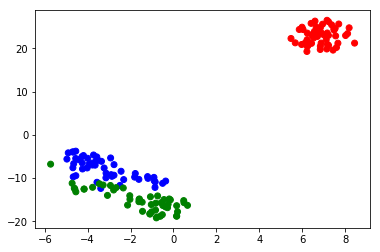

In [36]:
# https://github.com/pavlin-policar/fastTSNE you can try this also, this version is little faster than sklearn 
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

## [5.1] Applying TNSE on Text BOW vectors

In [37]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
print(std_data.shape)
# convert sparse to dense as tsne takes dense vector
std_data = std_data.todense()

(3989, 2475)


/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/techgig/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


/home/techgig/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'TSNE for Bag of Words')

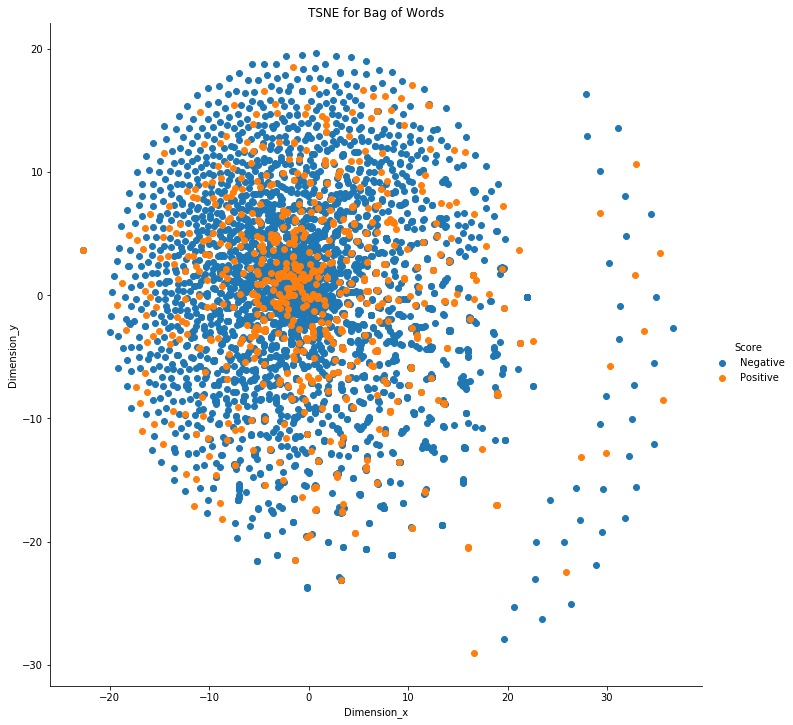

In [39]:
#Create a  TSNE Object
model = TSNE(n_components=2, perplexity=45, learning_rate=100, n_iter = 500, random_state=0)

for_tsne = model.fit_transform(std_data)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, final['Score'])).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for Bag of Words")

## [5.1] Applying TNSE on Text TFIDF vectors

(3989, 2475)


/home/techgig/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'tf Idf')

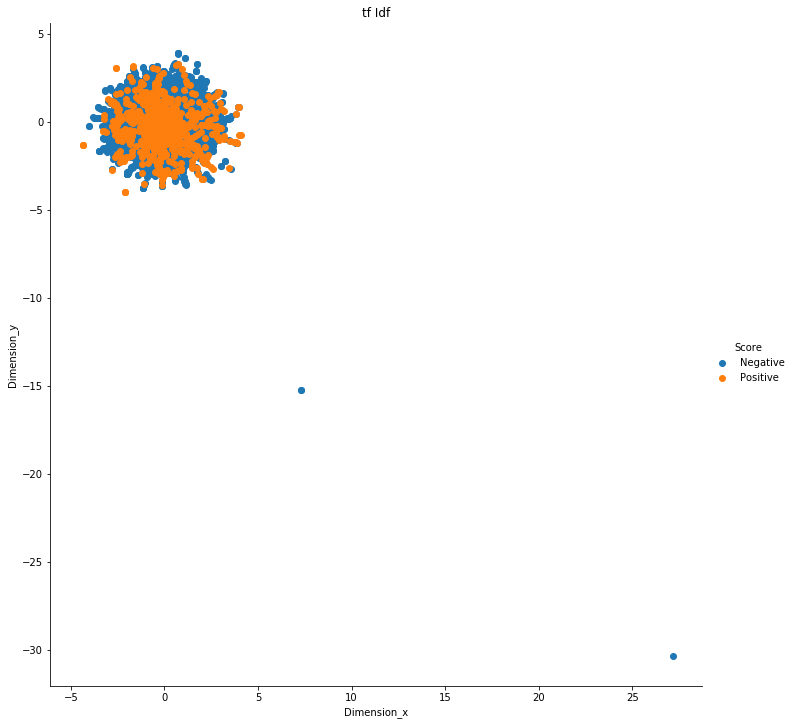

In [40]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.preprocessing import StandardScaler
std_data_tf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(std_data_tf.shape)
std_data_tf = std_data_tf.todense()
model_tf = TSNE(n_components=2,random_state=0,perplexity=30,n_iter=4000)
for_tsne_tf = model_tf.fit_transform(std_data_tf)
tsne_data_tf = np.vstack((for_tsne_tf.T,final['Score'])).T
for_tsne_tf_df = pd.DataFrame(data=tsne_data_tf, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_tf_df,hue='Score',size=10).map(plt.scatter,'Dimension_x','Dimension_y').add_legend()
plt.title("tf Idf")

## [5.3] Applying TNSE on Text Avg W2V vectors

<class 'numpy.ndarray'>


/home/techgig/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Text Average')

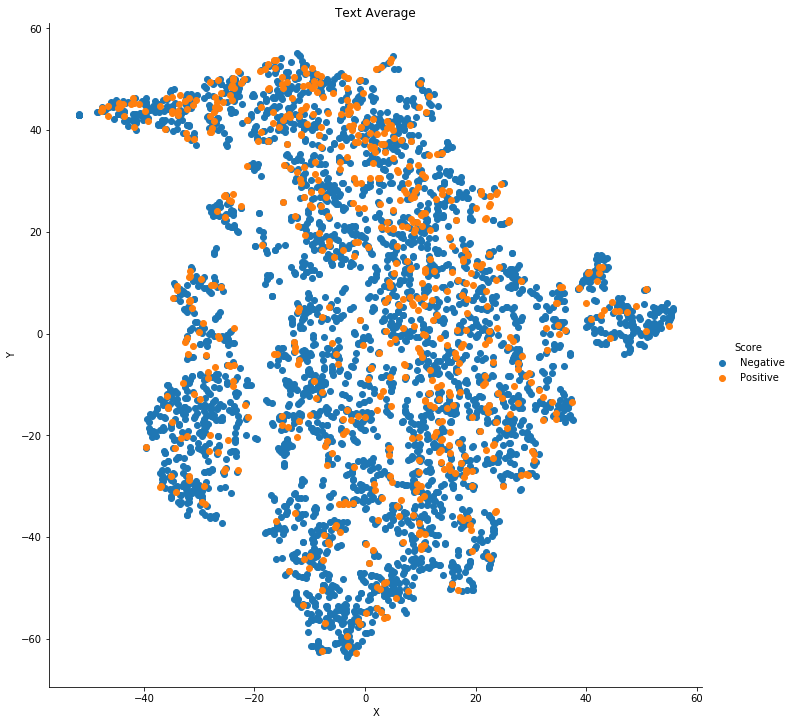

In [44]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
#scaling
std_data_wv = StandardScaler(with_mean=False).fit_transform(sent_vectors)
#std_data_wv = std_data_wv.todense()
print(type(std_data_wv))
model = TSNE(n_components=2, perplexity=30, learning_rate=600, n_iter=500)
tnse_text_avg = model.fit_transform(std_data_wv)
tnse_text_avg_bw = np.vstack((tnse_text_avg.T,final['Score'])).T
tnse_text_avg_df = pd.DataFrame(data = tnse_text_avg_bw,columns=['X','Y','Score'])
sns.FacetGrid(tnse_text_avg_df,hue="Score",size=10).map(plt.scatter,'X','Y').add_legend()
plt.title("Text Average")

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

/home/techgig/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'TFIDF Weighted Average')

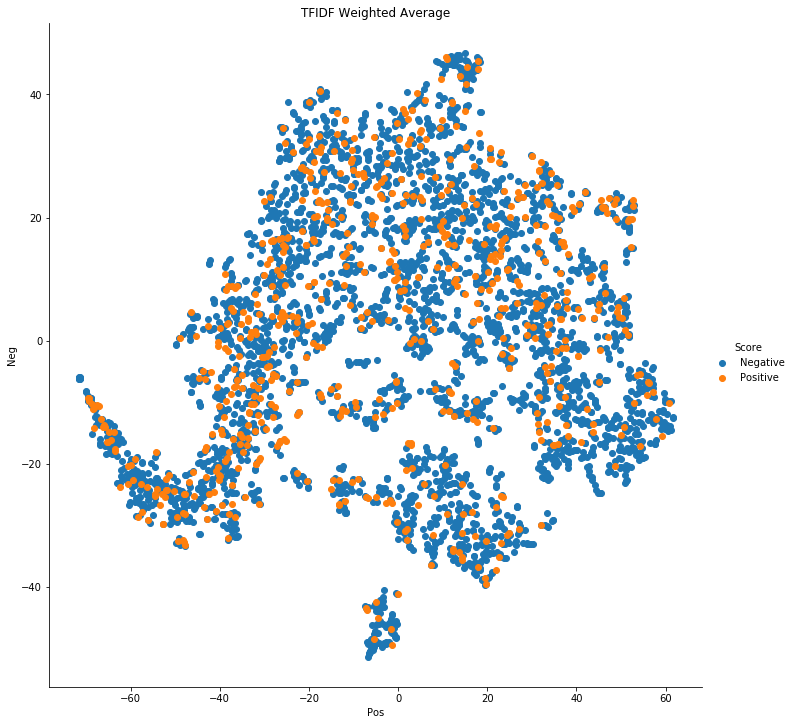

In [45]:
# please write all the code with proper documentation, and proper titles for each subsection
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
std_data_tf = StandardScaler(with_mean=False).fit_transform(tfidf_sent_vectors)
#std_data_tf = std_data_tf.todense()
model_tf_weight = TSNE(n_components=2,perplexity=30,learning_rate=600,n_iter=500)
tnse_weight_tf = model.fit_transform(std_data_tf)
tnse_text_tf = np.vstack((tnse_weight_tf.T,final['Score'])).T
tnse_text_df = pd.DataFrame(data=tnse_text_tf,columns=["Pos","Neg","Score"])
sns.FacetGrid(tnse_text_df,hue="Score",size=10).map(plt.scatter,'Pos','Neg').add_legend()
plt.title("TFIDF Weighted Average")


# [6] Conclusions
I realize None of the method seprates the positive and negative Review